In [ ]:
from bs4 import BeautifulSoup
import sys

def logL(x):
    
    #print(seq1[10],seq2[10])
    LogL = 0
    #len(seq1) -1
    for i in range(1,100): 
        
        #Tree structure, this should come from a .nex file
        N = 20
        #Sample size per loci
        n = 100
        T = Tree(np.array([[1,2],[3,4],[5,6]]),np.array([5,5,6,7,6,7]),x)
        #T = Tree(np.array([[1,2]]),np.array([3,3]),x)
        #Given frequency
        C = np.array([int(seq1[i]),int(seq2[i]),int(seq3[i]),int(seq4[i])])
        #Get Chebychev Coefficients of initial condition
        CC = np.zeros([len(C),N+1])
        for i in range(0,len(C)):
            CC[i] = Chebychev_transform2(n_sample,C[i],N) 
        #selection and mutation (multiply u,v by 2)    
        a = np.array([[0.006,-0.012,0,0],[0.005,-0.01,0,0]])
        #genetic drift
        b = np.array([0,0.5,-0.5,0])
        LogL += Tree_integrator(T,C,N,n,CC,a,b)
    return LogL


def BranchSupp(x):
	return all(0 < x )&all(x < 20)
###          we define the objective function with the U function
###          which is -log of the density function.
###          The support is defined in a separate function.
###   The dimension of the parameter space is n

'''Get the SimSnap simulations into format '''
handler = open("testSimSnap_tree_1.xml","r" )
contents = handler.read()
soup = BeautifulSoup(contents,'xml')
sequence = soup.find_all('sequence')
seq1 = sequence[0].text
seq2 = sequence[1].text
seq3 = sequence[2].text
seq4 = sequence[3].text
seq1 = seq1.split(",")
seq2 = seq2.split(",")
seq3 = seq3.split(",")
seq4 = seq4.split(",")

Tree_Inference = pytwalk( n=6, U=logL, Supp=BranchSupp)

#### This would run the twalk

Tree_Inference.Run( T=10000, x0=1*np.ones(6), xp0=2*np.ones(6))

Tree_Inference.Save("Tree_Inference_twalk1.dat")

#Gets output into Tracer format
x = Tree_Inference.Output
n = np.shape(x)
z = np.zeros([int(n[0])+1, int(n[1])+1])
z[1:,1:] = x
y = np.arange(0,n[0] +1)
z[:,0] = y
header = np.arange(1,n[1]+1)
header_str = str(np.arange(1,n[1]+1))
header_str = header_str[1:-1]
header_str = header_str.replace(" ", "\t")
np.savetxt( 'test.log', z, delimiter='\t', header='state' + header_str )

#Tree_Inference.Ana
#Tree_Inference.Hist( par=0 )

#plt.show()
#Tree_Inference.Hist( par=1 )
#plt.show()
#Tree_Inference.Hist( par=2 )
#plt.show()
#Tree_Inference.Hist( par=3 )
#plt.show()
#Tree_Inference.Hist( par=4 )
#plt.show()
#Tree_Inference.Hist( par=5 )
#plt.show()


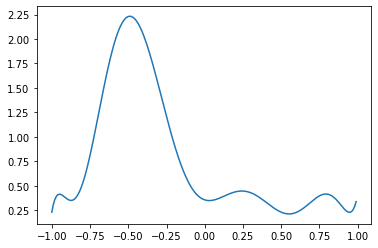

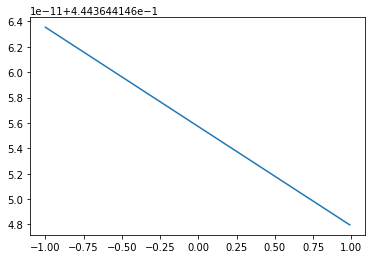

20.750891822175635

In [45]:
%matplotlib inline
import scipy.integrate as integrate
import scipy as sp
import scipy.stats as sps
import numpy as np
import numpy.polynomial.chebyshev as ch
from numpy.linalg import inv
from scipy.linalg import expm
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as ch
#from pytwalk import * 



class Tree:
    def __init__(self,structure_pc, structure_cp, time):
        self.structure_pc = structure_pc 
        self.structure_cp = structure_cp
        self.time = time
        
def x_times_Tx(N): #Transpose of Operator B defined as x*f(x) (Gordon's thesis Propositon.5 page. 78)
    B = sp.sparse.diags([0.25, 0.5, 0.25], [-1, 0, 1], shape=(N, N)).toarray()
    B[1,0] = 0.5
    return B

def Chebychev_transform2(n,m,N):
    circle = np.arange(0,np.pi+1/n,1/n)
    x = (np.cos(circle) + 1)/2
    f = sps.binom.pmf(m, n, x, loc=0)
    #specify Chebychev bases
    chebexp_shift = ch.Chebyshev.fit(x,f,N,domain=[0,1])
    return chebexp_shift.coef

def Dd(N): #Derivative operator
    D = np.zeros([N,N])
    D[0,np.arange(1,N,2)] = 2*np.arange(1,N,2)
    for i in range(0,N-2):
        D[i+1,np.arange(i+2,N,2)] = 4*(np.arange(i+1,N-1,2)+1)
    return D

def Tree_integrator(T,C,N,n_sample,CC,a,b): 
    nnodes = np.shape(T.structure_cp)[0] + 1
    n = (nnodes+1.)/2.
    F = np.zeros([N,nnodes])
    logL = 0
    circle = np.arange(0,np.pi+1/n_sample,1/n_sample)
    p = (np.cos(circle) + 1)/2
    #4.5 Proposition 5 Operator B
    S = x_times_Tx(N)
    S2 = np.dot(S,S)
    S3 = np.dot(S2,S)
    #First Derivative       
    D = Dd(N)
    #Second Derivative
    D2 = np.dot(D,D)
    #Q-matrix (although it's called M)
    M = (a[0,0]*D) + (a[0,1]*np.dot(S,D)) + (a[0,2]*np.dot(S2,D)) + (a[0,3]*np.dot(S3,D)) + .5*((b[0]*D2) + (b[1]*np.dot(S,D2)) + (b[2]*np.dot(S2,D2))) 
    
    #---step1-a---    
    j=0
    for i in range(0,int(n)): 
        tt = T.time[i] #branch length
        #these points have to be consistent with the number of points
        cc = CC[i,:]   
        j += 1
#---step1-b,c---
        F[:,i] = np.transpose(np.dot(expm(M*tt),cc[:-1]))
#---step2---  
    #Adhoc for now
    M = (a[1,0]*D) + (a[1,1]*np.dot(S,D)) + (a[1,2]*np.dot(S2,D)) + (a[1,3]*np.dot(S3,D)) + .5*((b[0]*D2) + (b[1]*np.dot(S,D2)) + (b[2]*np.dot(S2,D2))) 
    
    for i in range(int(n),nnodes-1):
#---step2-a,b,c---
        u = T.structure_pc[i - int(n),0]
        v = T.structure_pc[i - int(n),1]
        F1 = F[:,u-1]
        F2 = F[:,v-1]
        tt = T.time[i]
#---step2d---
#   4.3.3  Proposition 1
        F1chebpts = ch.chebval(2*p-1,  F1)
        F2chebpts = ch.chebval(2*p-1,  F2)
        Ffit = ch.Chebyshev.fit(p,F1chebpts*F2chebpts,N,domain=[0,1])
        cc = Ffit.coef            
#---step2-e,f---
        F[:,i] = np.transpose((np.dot(expm(M*tt),cc[:-1])))
#---step3---    
    r = nnodes - 1
    u = T.structure_pc[r - int(n),0]
    v = T.structure_pc[r - int(n),1]
#---step4,5---
    F1 = F[:,u-1]
    F2 = F[:,v-1]
#---step6--- #The root branch has zero length    
    f = lambda p: ch.chebval(2*p-1, F1)*ch.chebval(2*p-1, F2)*sps.beta.pdf(p,0.006,0.006)
    result = integrate.quad(f, 0, 1)
#---step7---    
    like = result[0]
    #print(like)
    if 1>=like>=0:
        logL = np.log(like)
    else:
        logL = -10000   
    return -logL

#Tree structure, this should come from a .nex file
T = Tree(np.array([[1,2],[3,4],[5,6]]),np.array([5,5,6,7,6,7]),np.array([0.1,0.1,0.1,0.1,0.1,0.1]))
#T = Tree(np.array([[1,2]]),np.array([3,3]),np.array([0.1,1]))
#Sample size
n = 100
# Number of red alleles
C = np.array([60,70, 65,50])
#Chebychev basis
N = 10
#Get Chebychev Coefficients of initial condition
CC = np.zeros([len(C),N+1])
for i in range(0,len(C)):
    CC[i] = Chebychev_transform2(n,C[i],N)  
#selection and mutation    
a = np.array([[.5,-1,0,0],[.4,-0.5,0,0]])
#genetic drift
b = np.array([0,0.5,-0.5,0])
#Return -likelihood
Tree_integrator(T,C,N,n,CC,a,b)

In [1]:
help(ch.Chebyshev.fit)

NameError: name 'ch' is not defined

In [9]:
def Chebychev_transform2(n,m,N):
    circle = np.arange(0,np.pi+np.pi/N,np.pi/N)
    x = (np.cos(circle) + 1)/2
    print(x)
    f = sps.binom.pmf(m, n, x, loc=0)
    #specify Chebychev bases
    print(f)
    chebexp_shift = ch.Chebyshev.fit(x,f,N,domain=[0,1])
    return chebexp_shift.coef

n = 20
m = 10
N =9
print(Chebychev_transform2(n,m,N))

[1.         0.96984631 0.88302222 0.75       0.58682409 0.41317591
 0.25       0.11697778 0.03015369 0.        ]
[0.00000000e+00 8.45341774e-11 2.55475097e-05 9.92227528e-03
 1.29726236e-01 1.29726236e-01 9.92227528e-03 2.55475097e-05
 8.45341774e-11 0.00000000e+00]
[ 3.10386798e-02 -9.74462778e-19 -5.63819947e-02  1.25125528e-17
  4.19515190e-02 -2.37061390e-17 -2.44238296e-02  1.09142675e-17
  7.81562546e-03  2.11399078e-18]


In [23]:
import numpy as np

values = np.array([0,2.06094e-19,8.74687e-11,3.4265e-06,0.00188369,0.0629126,0.202331,0.0525454,0.000244169,0])

coeff = np.fft.fft(values)
coeff = np.real(coeff)
print("Coefficient Values")
print(coeff)

values2 = np.fft.ifft(coeff)
print("Function Values")
print(np.real(values2))
print("difference")
print(np.sum(values - values2))

Coefficient Values
[ 0.31992029 -0.24428878  0.08330798  0.04250857 -0.08598662  0.08899743
 -0.08598662  0.04250857  0.08330798 -0.24428878]
Function Values
[0.         0.         0.00012208 0.02627441 0.10210734 0.0629126
 0.10210734 0.02627441 0.00012208 0.        ]
differnece
(6.4211873665454e-17+0j)


[0.2309234  0.30840844 0.36085197 0.39322287 0.40992208 0.41482523
 0.41132306 0.40235977 0.39046931 0.37780963 0.36619512 0.35712715
 0.3518229  0.35124243 0.3561142  0.3669589  0.38411192 0.40774428
 0.43788217 0.47442524 0.5171635  0.56579316 0.61993114 0.67912857
 0.74288326 0.81065102 0.88185619 0.95590111 1.03217482 1.11006088
 1.18894442 1.26821847 1.34728956 1.42558265 1.50254551 1.57765241
 1.65040736 1.72034671 1.78704144 1.85009881 1.90916374 1.96391973
 2.0140894  2.05943477 2.09975717 2.13489689 2.1647326  2.18918048
 2.20819321 2.22175872 2.2298988  2.23266756 2.23014975 2.222459
 2.20973594 2.19214626 2.1698787  2.14314302 2.11216788 2.0771988
 2.03849602 1.99633243 1.95099146 1.90276506 1.85195167 1.79885428
 1.74377849 1.68703065 1.62891612 1.5697375  1.50979306 1.44937516
 1.38876879 1.32825021 1.26808571 1.20853039 1.14982711 1.09220556
 1.03588134 0.98105521 0.92791248 0.87662239 0.82733772 0.78019442
 0.73531135 0.69279019 0.65271532 0.61515394 0.58015614 0.5477552

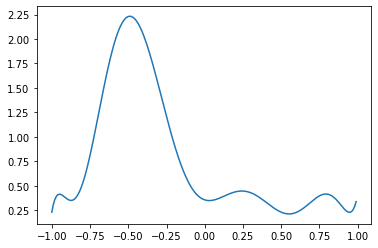

In [46]:
%matplotlib inline
import numpy.polynomial.chebyshev as ch
import matplotlib.pyplot as plt

coeff = np.array([0.639841,-0.304486,-0.305489,0.517986,-0.201729,-0.196992,0.287083,-0.105506,-0.0997856,0.177995])
x = np.arange(-1,1,0.01)
y = ch.chebval(x,coeff)
print(y)
plt.plot(x,y)
plt.show()

